In [1]:
#@title **OC SVM** v/s **GMM** classfier using pretrained *Resnet50* { display-mode: "form" }

#Intro


'Binary classification is arguably the most widely documented domain of supervised machine learning, at least within its application toward classifying non-Image data. In a ham vs spam email detector, the data for each class is bound by the limitations of the medium; each instance will most definitely be a variant of an email. However, an interesting problem arises when attempting to apply a ham vs spam concept with image classification.'
## The Problem

'Consider the issue that arises when building a model whose purpose it is to determine whether a car exists in its field of view. You may have several thousand images of cars you would like to train the model to recognize, but what about instances of “Not Car” images? It doesn’t take long for one to realize that unlike the data in the ham vs spam email problem, the amount of instances that qualify as “Not Car” are near infinite: infinity \ car if you want to be cheeky about it.'
'While there are several pretrained models for classifying cars, projects in an industry are not always so straightforward. When faced with one such project, I found the documentation around this “One Class Classification” idea to be pretty paltry. There were several recommendations of building a model with autoencoders, but as a infrequent practitioner of Keras and naive in the space of image classification overall, I found such methods to be a little hard to “pick up and go” within the span of a few hours (maybe one of you readers could contribute a kernel taking this approach for the rest of us).'

'I did find one promising article written by Aniket Bhatnagar on Hackernoon though. Instead of building a custom model with auto-encoders, Aniket outlined the process of extracting features with the popular ResNet50 model, scaling and reducing the dimensionality of such features, then using a selection of scikit-learn algorithms for classification; all of this while training only on positive class images (the GMM model however uses a combination of positive/not positive images in its validation set). '

'I implemented Aniket’s procedure to a project with industry data and was pleased with its results, even before optimization. However, while the article was very informative, it did not include the complete code to create a project from scratch, which is the inspiration behind this notebook. Aniket’s article is also listed below; I definitely recommend reading it alongside this notebook.'

'https://hackernoon.com/one-class-classification-for-images-with-deep-features-be890c43455d '

'https://hackernoon.com/one-class-classification-for-images-with-deep-features-be890c43455d '

### Keras implementation

# Download Data

In [ ]:
# Train data

!curl -L "https://app.roboflow.com/ds/07hjdLGFQf?key=VmTGRscuXp" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   889  100   889    0     0   1706      0 --:--:-- --:--:-- --:--:--  1703
100 16.0M  100 16.0M    0     0  16.1M      0 --:--:-- --:--:-- --:--:-- 16.1M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: train/
   creating: train/invoice/
 extracting: train/invoice/00001121Statement01-05-2020-1_jpg.rf.d5ff36be9d7e05255d902fa5f75853cb.jpg  
 extracting: train/invoice/079D49F-1_jpg.rf.8d9854a466cab8f043849ffca0bdfad2.jpg  
 extracting: train/invoice/0931683_2-1_jpg.rf.721cab568a2f8638876c414698223605.jpg  
 extracting: train/invoice/10160522-1_jpg.rf.7d0b7f6a13c1c5b7e41db18b7f2822d0.jpg  
 extracting: train/invoice/10161104-1_jpg.rf.ae2a5cd773e74cce1a9c8800528749fc.jpg  
 extracting: train/invoice/10162436-1_jpg.rf.43781030115f72732cd920ceed95867a.jpg  
 extracting: train/invoice/10166887-1_jpg.rf.af6ddd4

In [ ]:
# Test Data

!curl -L "https://tmpfiles.org/dl/165600/test.zip" > test.zip; unzip test.zip; rm test.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.7M  100 28.7M    0     0  6454k      0  0:00:04  0:00:04 --:--:-- 6847k
Archive:  test.zip
   creating: test/
   creating: test/invoice/
  inflating: test/invoice/2q2.jpg    
  inflating: test/invoice/3001123117453T0-1.jpg  
  inflating: test/invoice/af afwfaw.jpg  
   creating: test/others/
  inflating: test/others/111.jpg     
  inflating: test/others/22222.jpg   
  inflating: test/others/3018093126017T0-1.jpg  
  inflating: test/others/3333.jpg    
  inflating: test/others/4444.jpg    
  inflating: test/others/Activity_Statement_for_Gradian_Project_01Jun2020-30Jun2020-1.jpg  
  inflating: test/others/Architecture-1.jpg  
  inflating: test/others/Architecture-2.jpg  
  inflating: test/others/Architecture-3.jpg  
  inflating: test/others/Architecture-4.jpg  
  inflating: test/others/Architecture-5.jpg  
  inflating: test/o

In [ ]:
%cd ../
%ls

/content
models/  README.roboflow.txt  sample_data/  test/  train/  valid/


In [ ]:
# Download ResNet model

%mkdir models
%cd models
!curl -L "https://awscdk-documentsbucket9ec9deb9-i5bemy0nz6wp.s3-ap-southeast-2.amazonaws.com/resnet50.zip" > models.zip; unzip models.zip; rm models.zip
%cd ../

/content/models
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  174M  100  174M    0     0  15.1M      0  0:00:11  0:00:11 --:--:-- 18.2M
Archive:  models.zip
  inflating: imagenet_class_index.json  
  inflating: resnet50_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5  
/content


# Import libraries

In [ ]:
# import libraries
from IPython.display import Image, display
import numpy as np
import os
from os.path import join
from PIL import ImageFile
import pandas as pd
from matplotlib import cm
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.isotonic import IsotonicRegression
import re

ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.style.use('fivethirtyeight')
%matplotlib inline

# Data Preprocessing

In [ ]:
# import car images from train
train_img_dir_n = "train/invoice"
train_img_paths_n = [join(train_img_dir_n,filename) for filename in os.listdir(train_img_dir_n)]

In [ ]:
# import car images from valid
train_img_dir_s = "valid/invoice"
all_train_img_paths_s = [join(train_img_dir_s,filename) for filename in os.listdir(train_img_dir_s)]

# split cars data into train, test, and val
train_img_paths, test_img_paths_car = train_test_split(all_train_img_paths_s+train_img_paths_n, test_size=0.25, random_state=42)
train_img_paths, val_img_paths_car = train_test_split(train_img_paths, test_size=0.25, random_state=42)

In [ ]:
# import test data for No invoice

natural_images_path = "test/"
test_img_paths_no_car = []
for d in [d for d in os.listdir("test/") if d!= "invoice"]:
    test_img_dir_na = natural_images_path+d
    test_img_paths_no_car.append([join(test_img_dir_na,filename) for filename in os.listdir(test_img_dir_na)])

print(len(test_img_paths_no_car), test_img_paths_no_car)
test_img_paths_no_car_flat = [item for sublist in test_img_paths_no_car for item in sublist]
test_img_paths_no_car, val_img_paths_no_car = train_test_split(test_img_paths_no_car_flat, test_size = 0.25, random_state = 42)

1 [['test/others/CB_ApplicationForm_741952-9.jpg', 'test/others/CB_ApplicationForm_741952-1.jpg', 'test/others/Friendlies_Footbridge_-_Complete_Set_(20-05-20)-10.jpg', 'test/others/deposit_slip_PDF-1.jpg', 'test/others/CB_ApplicationForm_741952-6.jpg', 'test/others/DOC140420-14042020131750-4.jpg', 'test/others/Gradian_Projects_3_Timesheet_August_2020-1.jpg', 'test/others/page-6.jpg', 'test/others/DBC_Terms_&_Conditions-3.jpg', 'test/others/Google_OAuth_Guide-12.jpg', 'test/others/CB_ApplicationForm_741952-5.jpg', 'test/others/board-resolution-for-appointment-of-first-auditors-of-the-company-1.jpg', 'test/others/CB_ApplicationForm_741952-4.jpg', 'test/others/Google_OAuth_Guide-13.jpg', 'test/others/3333.jpg', 'test/others/Friendlies_Footbridge_-_Complete_Set_(20-05-20)-03.jpg', 'test/others/Architecture-1.jpg', 'test/others/page-4.jpg', 'test/others/DOC071520-07152020112041-4.jpg', 'test/others/Architecture-2.jpg', 'test/others/Boom_Lift_Hire_details_form_-_Gradian_Projects-1.jpg', 'tes

In [ ]:
def natural_img_dir(image_path):
    path_regex = r"test\/(\w*)"
    if 'test' in image_path:
        return re.findall(path_regex,image_path,re.MULTILINE)[0].strip()
    else:
        return 'invoice'

In [ ]:
# create test dataframe
all_test_paths = test_img_paths_car+test_img_paths_no_car
test_path_df = pd.DataFrame({
    'path': all_test_paths,
    'is_invoice': [1 if path in test_img_paths_car else 0 for path in all_test_paths]
})
test_path_df = shuffle(test_path_df,random_state = 0).reset_index(drop = True)
test_path_df['image_type'] = test_path_df['path'].apply(lambda x: natural_img_dir(x))
all_test_paths = test_path_df['path'].tolist()
print(test_path_df)

                                                  path  is_invoice image_type
0    train/invoice/301014_0_3123458T0-2_jpg.rf.ab61...           1    invoice
1    valid/invoice/Invoice_76_jpg.rf.eff747f19c1bed...           1    invoice
2    train/invoice/Invoice_191_jpg.rf.82c4156e1defb...           1    invoice
3    test/others/Boom_Lift_Hire_details_form_-_Grad...           0     others
4    train/invoice/5401_Gradian_Projects_INV2080-1_...           1    invoice
..                                                 ...         ...        ...
131  train/invoice/Invoice_56_jpg.rf.7ecf2510bc49a6...           1    invoice
132  test/others/Friendlies_Footbridge_-_Complete_S...           0     others
133  valid/invoice/Invoice_97_jpg.rf.0a71cc46f3aeee...           1    invoice
134              test/others/Google_OAuth_Guide-11.jpg           0     others
135  train/invoice/EStatement-1_jpg.rf.7d3237401d71...           1    invoice

[136 rows x 3 columns]


In [ ]:
print('Distribution of Image Types in Test Set')
print(test_path_df['image_type'].value_counts())

Distribution of Image Types in Test Set
invoice    71
others     65
Name: image_type, dtype: int64


In [ ]:
# create val dataframe
all_val_paths = val_img_paths_car+val_img_paths_no_car
val_path_df = pd.DataFrame({
    'path': all_val_paths,
    'is_car': [1 if path in val_img_paths_car else 0 for path in all_val_paths]
})
val_path_df = shuffle(val_path_df,random_state = 0).reset_index(drop = True)
val_path_df['image_type'] = val_path_df['path'].apply(lambda x: natural_img_dir(x))
all_val_paths = val_path_df['path'].tolist()

In [ ]:
print('Distribution of Image Types in Validation Set')
print(val_path_df['image_type'].value_counts())

Distribution of Image Types in Validation Set
invoice    54
others     22
Name: image_type, dtype: int64


# Feature Extraction With ResNet50
Removing the prediction layer of the pretrained Resnet50 model allows features to quickly be extracted from selected images.

In [ ]:
# prepare images for resnet50
image_size = 224

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    #output = img_array
    output = preprocess_input(img_array)
    return(output)

X_train = read_and_prep_images(train_img_paths)
X_test = read_and_prep_images(all_test_paths)
X_val = read_and_prep_images(all_val_paths)

In [ ]:
# get features from resnet50 

# !curl -L 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5' > resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# resnet_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

resnet_weights_path = 'models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# X : images numpy array
resnet_model = ResNet50(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False, pooling='avg')  # Since top layer is the fc layer used for predictions

X_train = resnet_model.predict(X_train)
X_test = resnet_model.predict(X_test)
X_val = resnet_model.predict(X_val)

94773248/94765736 [==============================] - 1s 0us/step


# Scaling and PCA
Reducing the dimensionality of extracted features allow for quicker training times.

In [ ]:
# Apply standard scaler to output from resnet50
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)

# Take PCA to reduce feature space dimensionality
pca = PCA(n_components=20, whiten=True)
pca = pca.fit(X_train)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

Explained variance percentage = 0.67


# One Class SVM vs Isolation Forest
These two models can be trained on solely positive class, cars for this project, images, without the need for a validation set.

In [ ]:
# Train classifier and obtain predictions for OC-SVM
oc_svm_clf = svm.OneClassSVM(gamma=0.001, kernel='rbf', nu=0.08)  # Obtained using grid search
if_clf = IsolationForest(contamination=0.08, max_features=1.0, max_samples=1.0, n_estimators=40)  # Obtained using grid search

oc_svm_clf.fit(X_train)
if_clf.fit(X_train)

oc_svm_preds = oc_svm_clf.predict(X_test)
if_preds = if_clf.predict(X_test)

# Further compute accuracy, precision and recall for the two predictions sets obtained

In [ ]:
svm_if_results=pd.DataFrame({
  'path': all_test_paths,
  'oc_svm_preds': [0 if x == -1 else 1 for x in oc_svm_preds],
  'if_preds': [0 if x == -1 else 1 for x in if_preds]
})


svm_if_results=svm_if_results.merge(test_path_df)
svm_if_results.head()

,path,oc_svm_preds,if_preds,is_invoice,image_type
0,train/invoice/301014_0_3123458T0-2_jpg.rf.ab61...,1,1,1,invoice
1,valid/invoice/Invoice_76_jpg.rf.eff747f19c1bed...,1,1,1,invoice
2,train/invoice/Invoice_191_jpg.rf.82c4156e1defb...,1,1,1,invoice
3,test/others/Boom_Lift_Hire_details_form_-_Grad...,1,1,0,others
4,train/invoice/5401_Gradian_Projects_INV2080-1_...,1,1,1,invoice


roc auc score: if_preds
0.6
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        65
           1       0.58      1.00      0.73        71

    accuracy                           0.62       136
   macro avg       0.79      0.60      0.53       136
weighted avg       0.78      0.62      0.54       136



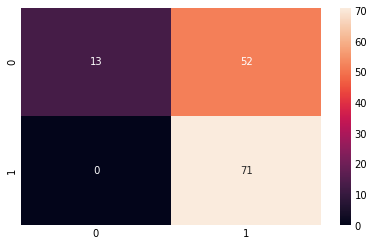

In [ ]:
print('roc auc score: if_preds')
if_preds=svm_if_results['if_preds']
actual=svm_if_results['is_invoice']
print(roc_auc_score(actual, if_preds))
print(classification_report(actual, if_preds))
sns.heatmap(confusion_matrix(actual, if_preds),annot=True,fmt='2.0f')
plt.show()

roc auc score: oc_svm_preds
0.5852654387865656
              precision    recall  f1-score   support

           0       0.92      0.18      0.31        65
           1       0.57      0.99      0.72        71

    accuracy                           0.60       136
   macro avg       0.75      0.59      0.51       136
weighted avg       0.74      0.60      0.52       136



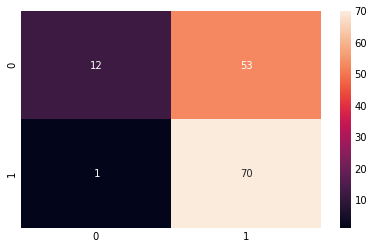

In [ ]:
print('roc auc score: oc_svm_preds')
oc_svm_preds=svm_if_results['oc_svm_preds']
actual=svm_if_results['is_invoice']
print(roc_auc_score(actual, oc_svm_preds))
print(classification_report(actual, oc_svm_preds))
sns.heatmap(confusion_matrix(actual, oc_svm_preds),annot=True,fmt='2.0f')
plt.show()

# **Gaussian Mixture and Isotonic Regression**
These models leverage validation data to additionally learn distinctions between positive and not positive class images. With real world problems, the data scientist might have a hunch on what "not positive images" might appear alongside its positive counterparts; these selections would be appropriate to include in the validation data. For example, a marine biologist may ask a data scientist to perform One Class Clasification to return only images with a shark in the photo. To leverage the GMM model below, the data scientist might choose to also include non-shark fishes, whales, and open ocean images in the validation data alongside some shark images.

In [ ]:
y_val = val_path_df['is_car'].tolist()

gmm_clf = GaussianMixture(covariance_type='spherical', n_components=18, max_iter=int(1e7))  # From Article (These params should be optimized for this problem)
gmm_clf.fit(X_train)
log_probs_val = gmm_clf.score_samples(X_val)
isotonic_regressor = IsotonicRegression(out_of_bounds='clip')
isotonic_regressor.fit(log_probs_val, y_val)  # y_val is for labels 0 - not car 1 - car (validation set)

# Obtaining results on the test set
log_probs_test = gmm_clf.score_samples(X_test)
test_probabilities = isotonic_regressor.predict(log_probs_test)
test_predictions = [1 if prob >= 0.5 else 0 for prob in test_probabilities]

In [ ]:
gmm_results = pd.DataFrame({
  'path': all_test_paths,
  'gmm_preds': test_predictions
})

gmm_results = gmm_results.merge(test_path_df)
gmm_results.head()

,path,gmm_preds,is_invoice,image_type
0,train/invoice/301014_0_3123458T0-2_jpg.rf.ab61...,1,1,invoice
1,valid/invoice/Invoice_76_jpg.rf.eff747f19c1bed...,1,1,invoice
2,train/invoice/Invoice_191_jpg.rf.82c4156e1defb...,1,1,invoice
3,test/others/Boom_Lift_Hire_details_form_-_Grad...,1,0,others
4,train/invoice/5401_Gradian_Projects_INV2080-1_...,1,1,invoice


roc auc score: gmm_preds
0.6166847237269772
              precision    recall  f1-score   support

           0       0.89      0.26      0.40        65
           1       0.59      0.97      0.73        71

    accuracy                           0.63       136
   macro avg       0.74      0.62      0.57       136
weighted avg       0.74      0.63      0.58       136



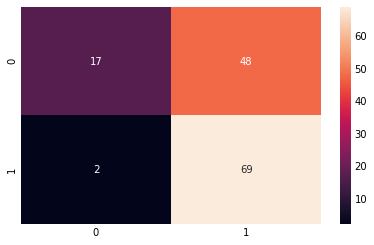

In [ ]:
print('roc auc score: gmm_preds')
gmm_preds = gmm_results['gmm_preds']
actual = gmm_results['is_invoice']
print(roc_auc_score(actual, gmm_preds))
print(classification_report(actual, gmm_preds))
sns.heatmap(confusion_matrix(actual, gmm_preds),annot = True,fmt = '2.0f')
plt.show()

## **Error Analysis**

The OC SVM and IF models had fewer False Positives but more False Negatives compared to the GMM model, with the OC SVM model outperforming the IF one. Depending on the use case of a project, it might be wiser to choose the OC SVM over the GMM or vice versa. A fulfillment center might opt to use the OC SVM model as it has fewer False Positives, meaning when it chooses to pack an object, such as a toy car, it is more likely to pack the right object than the GMM model. However, a healthcare imaging device may be favor the GMM more, as making a False Negative is much more costly to the patient than a False Positive.

Looking at the types of images of the False Positives, it isn't surprising to see that motorbikes were the most commonly mispredicted as a car as the presence of wheels and metal chassis share similarities.

A naive look at the cars in the False Negative class show that images of exotic cars and cars shot at atypical angles or with other objects in the view were among the cars mispredicted as non-cars.

In [ ]:
print('False Positive Actual Image Types for OC SVM: ')
print(svm_if_results[svm_if_results['oc_svm_preds']>svm_if_results['is_invoice']]['image_type'].value_counts())

False Positive Actual Image Types for OC SVM: 
others    53
Name: image_type, dtype: int64


In [ ]:
for index, row in svm_if_results[svm_if_results['oc_svm_preds']!=svm_if_results['is_invoice']].head(5).iterrows():
    if row['oc_svm_preds']==1:
        print('FALSE POSITIVE')
        print('oc_svm_preds: ' + str(row['oc_svm_preds']) + ' | actual: '+ str(row['is_invoice']))
        # display(Image(row['path']))
    else:
        print('FALSE NEGATIVE')
        print('oc_svm_preds: ' + str(row['oc_svm_preds']) + ' | actual: '+ str(row['is_invoice']))
        # display(Image(row['path']))

FALSE POSITIVE
oc_svm_preds: 1 | actual: 0
FALSE POSITIVE
oc_svm_preds: 1 | actual: 0
FALSE POSITIVE
oc_svm_preds: 1 | actual: 0
FALSE POSITIVE
oc_svm_preds: 1 | actual: 0
FALSE POSITIVE
oc_svm_preds: 1 | actual: 0


In [ ]:
print('False Positive Actual Image Types for IF: ')
print(svm_if_results[svm_if_results['if_preds']>svm_if_results['is_invoice']]['image_type'].value_counts())

False Positive Actual Image Types for IF: 
others    52
Name: image_type, dtype: int64


In [ ]:
for index, row in svm_if_results[svm_if_results['if_preds']!=svm_if_results['is_invoice']].head(5).iterrows():
    if row['if_preds']==1:
        print('FALSE POSITIVE')
        print('if_preds: ' + str(row['if_preds']) + ' | actual: '+ str(row['is_invoice']))
        # display(Image(row['path']))
    else:
        print('FALSE NEGATIVE')
        print('if_preds: ' + str(row['if_preds']) + ' | actual: '+ str(row['is_invoice']))
        # display(Image(row['path']))

FALSE POSITIVE
if_preds: 1 | actual: 0
FALSE POSITIVE
if_preds: 1 | actual: 0
FALSE POSITIVE
if_preds: 1 | actual: 0
FALSE POSITIVE
if_preds: 1 | actual: 0
FALSE POSITIVE
if_preds: 1 | actual: 0


In [ ]:
print('False Positive Actual Image Types for GMM: ')
print(gmm_results[gmm_results['gmm_preds']>gmm_results['is_invoice']]['image_type'].value_counts())

False Positive Actual Image Types for GMM: 
others    48
Name: image_type, dtype: int64


In [ ]:
for index, row in gmm_results[gmm_results['gmm_preds']!=gmm_results['is_invoice']].head(5).iterrows():
    if row['gmm_preds']==1:
        print('FALSE POSITIVE')
        print('gmm_preds: ' + str(row['gmm_preds']) + ' | actual: '+ str(row['is_invoice']))
        # display(Image(row['path']))
    else:
        print('FALSE NEGATIVE')
        print('gmm_preds: ' + str(row['gmm_preds']) + ' | actual: '+ str(row['is_invoice']))
        # display(Image(row['path']))

FALSE POSITIVE
gmm_preds: 1 | actual: 0
FALSE POSITIVE
gmm_preds: 1 | actual: 0
FALSE POSITIVE
gmm_preds: 1 | actual: 0
FALSE POSITIVE
gmm_preds: 1 | actual: 0
FALSE POSITIVE
gmm_preds: 1 | actual: 0
